In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from time import time
from copy import copy
from tqdm.notebook import tqdm
from multiprocessing import Pool
from simulation import Simulation_Base
from mip_solver import MIP_solver
from multiprocessing import Process, Queue

ind_libs_best_glob = np.array([602, 522, 972, 157, 393, 100, 717,  72, 715, 466,  61,  59, 390,
       708,  37,  87, 607, 902, 813, 933, 952, 693, 506, 600, 158, 779,
       970,  27, 244, 665, 808, 209, 594, 690,  82, 959, 597, 178,   4,
       495, 388, 239, 476, 491, 848,  69, 387, 854,  23, 894, 969, 125,
       626, 270, 304, 478, 241, 148, 669, 736, 350, 589, 700, 944, 343,
       232, 678, 691, 971, 443, 267,   0, 852, 793, 245, 520, 828, 795,
       606, 512, 772, 575, 639, 447, 566, 844, 112, 830, 140, 653, 320,
       366, 191, 621, 737, 633,  71, 411, 160, 428, 630,  80, 316, 455,
       676, 536, 834, 798, 179, 105, 569, 510, 809, 333, 242,  56,  45,
       650, 358, 389,  62, 336, 911, 973, 234, 273, 323, 151,  21, 184,
       950, 472, 457, 200, 332, 709, 516, 233, 646, 128, 687, 217, 212,
       571, 252, 202, 135, 716,  85, 543,  81, 936, 164,  91,  83, 853,
       773, 710, 433, 247,  66, 565,  32, 805])

class Simulation_E(Simulation_Base):
    number = 4
    cutoff_eff = 1
    exponent_book_points = 0.85
    boundary = 156
    max_distance = 20
    num_workers = 6
    
    def __init__(self, silent=False, seed=1337):
        np.random.seed(seed)
        Simulation_Base.__init__(self, number=self.number, silent=silent)
        
    def get_books_sorted(self, books):
        ranking = self.book_points[books] 
        indices_sorted = np.argsort(ranking)[::-1]
        return np.array(books)[indices_sorted]
        
    def init_ind_lib_current(self):
        self.lib_efficiencies = self.lib_ships / self.lib_days
        self.lib_available = (self.lib_efficiencies >= self.cutoff_eff).astype(int)
        self.ind_libs_current = np.where(self.lib_available == 1)[0]    
        
        self.length_ind_libs_current = len(self.ind_libs_current) 
        self.max_num_books = self.lib_num_books.max()
        self.lib_books_points = []
        self.book_num_libs_current = [0 for _ in range(self.num_books)]
        self.book_libs_current = [[] for _ in range(self.num_books)]
        for lib in self.ind_libs_current:
            books = self.lib_books_lists[lib]
            for book in books:
                self.book_libs_current[book].append(lib)
                self.book_num_libs_current[book] += 1
        self.book_num_libs_current = np.array(self.book_num_libs_current)
        self.book_libs_current = [np.array(libs) for libs in self.book_libs_current]
                
        for books in self.lib_books_lists:
            books_sorted = self.get_books_sorted(books)
            points_aug = np.concatenate([np.array([0]), np.array(self.book_points[books_sorted]), np.zeros(self.max_num_books - len(books), dtype = int)])
            self.lib_books_points.append(points_aug)
        self.lib_books_points = np.stack(self.lib_books_points) ** self.exponent_book_points
        self.lib_books_points_cum = np.cumsum(self.lib_books_points, axis = 1)
        self.energy_current = self.get_energy(self.ind_libs_current)
        
        self.ind_book_available = np.where(self.book_num_libs_current > 0)[0]
        self.book_importance = self.book_points[self.ind_book_available ]
        self.ind_book_sorted = self.ind_book_available[np.argsort(-self.book_importance)]
    
    def get_ind_libs_next_shift(self):
        lo = np.random.randint(0, self.boundary - 1)
        dist_max = np.random.randint(1, min(self.boundary-lo, self.max_distance))
        dist = np.random.randint(1, dist_max+1)
        hi = lo + dist
        ind_libs_next = copy(self.ind_libs_current)
        if np.random.rand() > 0.5:
            tmp = ind_libs_next[lo]
            ind_libs_next[lo:hi-1] = self.ind_libs_current[lo+1:hi]
            ind_libs_next[hi-1] = tmp            
        else:
            tmp = ind_libs_next[hi-1]
            ind_libs_next[lo+1:hi] = self.ind_libs_current[lo:hi-1]
            ind_libs_next[lo] = tmp    
        return ind_libs_next
    
    def get_ind_libs_next_swap(self):
        lo = np.random.randint(0, self.boundary - 1)
        dist_max = np.random.randint(1, min(self.boundary-lo, self.max_distance))
        dist = np.random.randint(1, dist_max+1)
        hi = lo + dist      
        ind_libs_next = copy(self.ind_libs_current)
        ind_libs_next[lo] = self.ind_libs_current[hi]
        ind_libs_next[hi] = self.ind_libs_current[lo]
        return ind_libs_next
    
    def get_ind_libs_next_explore(self):
        lo = np.random.randint(0, self.boundary - 1)
        hi = np.random.randint(self.boundary, self.length_ind_libs_current)
        ind_libs_next = copy(self.ind_libs_current)
        ind_libs_next[lo] = self.ind_libs_current[hi]
        ind_libs_next[hi] = self.ind_libs_current[lo]
        return ind_libs_next        
    
    def get_ind_libs_next(self):
        self.switch =  np.random.randint(3)
        if self.switch == 0:
            return self.get_ind_libs_next_shift()
        if self.switch == 1:
            return self.get_ind_libs_next_swap()
        if self.switch == 2:
            return self.get_ind_libs_next_explore()

    def get_energy(self, ind_libs):
        days_remaining = self.num_days - np.cumsum(self.lib_days[ind_libs])
        books_remaining = np.clip(days_remaining * self.lib_ships[ind_libs], 0, self.max_num_books)
        points = self.lib_books_points_cum[ind_libs, books_remaining]
        return - points.sum()

    def get_energy_approx(self, ind_libs):
        days_remaining = self.num_days - np.cumsum(self.lib_days[ind_libs])
        ind_lib_books_ship_remaining = np.clip(days_remaining * self.lib_ships[ind_libs], 0, None)
        ind_lib_books_inventory_remaining = self.lib_num_books[ind_libs]
        
        lib_ind_libs = np.zeros(self.num_libs, dtype=int)
        for ind, lib in enumerate(ind_libs):
            lib_ind_libs[lib] = ind
        
        ind_lib_ratio = ind_lib_books_ship_remaining / ind_lib_books_inventory_remaining
        points_total = 0
        for book in self.ind_book_sorted:
            ind_libs = lib_ind_libs[self.book_libs_current[book]]
            ind_lib_best = ind_libs[np.argmax(ind_lib_ratio[ind_libs])]
            if ind_lib_books_ship_remaining[ind_lib_best] > 0:
                points_total += self.book_points[book]
                ind_lib_books_ship_remaining[ind_lib_best] -= 1
                ind_lib_books_inventory_remaining[ind_lib_best] -= 1
                ind_lib_ratio[ind_lib_best] = ind_lib_books_ship_remaining[ind_lib_best] / ind_lib_books_inventory_remaining[ind_lib_best] 
        return - points_total
    
    def get_energy_optimal(self, ind_libs):
        days_remaining = np.clip(self.num_days - np.cumsum(self.lib_days[ind_libs]), 0, self.num_days)
        num_libs = np.argwhere(days_remaining != 0).shape[0]
        self.solution = self.mip.get_optimal_books_for_ordered_libs(ind_libs[:num_libs])
        return - self.get_score()
    
    def transition(self, energy_func):
        ind_libs_next = self.get_ind_libs_next()
        self.energy_next = energy_func(ind_libs_next)
        tresh = np.exp((self.energy_current - self.energy_next) / self.temperature)
        if np.random.rand() < tresh:
            self.energy_current = self.energy_next
            self.ind_libs_current = ind_libs_next
            
    def get_current_score(self):
        days_remaining = np.clip(self.num_days - np.cumsum(self.lib_days[self.ind_libs_current]), 0, self.num_days)
        num_libs = np.argwhere(days_remaining != 0).shape[0]
        self.ind_libs_best = self.ind_libs_current[:num_libs]
        self.solution = self.mip.get_optimal_books_for_ordered_libs(self.ind_libs_best)
        return self.get_score()
        
    def run_burn_in(self):
        self.temperature = 10000
        for i in tqdm(range(50001)):
            self.transition(self.get_energy)
            if i % 200 == 0:
                self.temperature = np.clip(self.temperature / 1.05, 0.4, None)        
            if i % 10000 == 0:
                points = - self.get_energy_approx(self.ind_libs_current)
                print(self.energy_current, self.temperature, self.max_distance, points)
        print(self.lib_efficiencies[self.ind_libs_current])
     
    def setup_approx_process(self, ind_libs_current):
        self.init_ind_lib_current()
        self.temperature = 0.1
        self.ind_libs_current = ind_libs_current
        self.energy_current = self.get_energy_approx(self.ind_libs_current)
    
    def setup_optimal_process(self, ind_libs_current):
        self.init_ind_lib_current()
        self.temperature = 0.1
        self.ind_libs_current = ind_libs_current
        self.mip = MIP_solver(self)
        self.energy_current = self.get_energy_optimal(sim.ind_libs_current)    
    
    def run_processing(self, process_func):
        q = Queue()
        q.put((0, copy(self.ind_libs_current), 0))
        processes = []
        for _ in range(self.num_workers):
            seed = np.random.randint(1,1337)
            p = Process(target=process_func, args=(q,seed,copy(self.ind_libs_current)))
            p.start()        
            processes.append(p)
        for p in processes:
            p.join()
        self.energy_current, self.ind_libs_current, _ = q.get()
        
                
    def run(self):
        self.init_ind_lib_current()
        
#         self.run_burn_in()
        self.ind_libs_current = ind_libs_best_glob
#         self.run_processing(process_function_approx)
#         self.run_processing(process_function_optimal)
        self.mip = MIP_solver(self)
        print(self.get_current_score())
        

                

def process_function_approx(q, seed, ind_libs_current):
    sim = Simulation_E(seed=seed)
    sim.setup_approx_process(ind_libs_current)
    while True:
        sim.transition(sim.get_energy_approx)
        energy_queue, ind_libs_queue, iter_queue = q.get()
        if sim.energy_current <= energy_queue:
            if sim.energy_current < energy_queue:
                print(sim.energy_current, "new minima!", iter_queue)
#                 print([sim.ind_libs_current])
            ind_libs_queue = sim.ind_libs_current
            energy_queue = sim.energy_current
        
        q.put((energy_queue, ind_libs_queue, iter_queue+1))
        if iter_queue > 1000:
            break

def process_function_optimal(q, seed, ind_libs_current):
    sim = Simulation_E(seed=seed)
    sim.setup_optimal_process(ind_libs_current)
    while True:
        sim.transition(sim.get_energy_optimal)
        energy_queue, ind_libs_queue, iter_queue = q.get()
        print(sim.energy_current, sim.energy_current - sim.energy_next, sim.switch, iter_queue)
        if sim.energy_current <= energy_queue:
            if sim.energy_current < energy_queue:
                print(sim.energy_current, "new minima!", iter_queue)
                print([sim.ind_libs_current])
            ind_libs_queue = sim.ind_libs_current
            energy_queue = sim.energy_current
        q.put((energy_queue, ind_libs_queue, iter_queue+1))
        if iter_queue > 1000:
            break
        


                
                
sim = Simulation_E()
sim.run()
print(sim.get_score())
sim.write()

5240723
5240723


In [31]:
ind_libs_sorted

array([602, 522, 972, 157, 393, 100, 717,  72, 715, 466,  61,  59, 390,
       708,  37,  87, 607, 902, 813, 933, 952, 693, 506, 600, 158, 779,
       970,  27, 244, 665, 808, 209, 594, 690,  82, 959, 178, 597,   4,
       495, 388, 239, 476, 491, 387, 848, 854,  23, 969, 894,  69, 125,
       626, 270, 304, 478, 241, 148, 669, 736, 350, 589, 700, 944, 343,
       232, 678, 691, 971, 443, 267,   0, 852, 793, 245, 520, 828, 795,
       606, 512, 772, 575, 639, 447, 566, 844, 112, 830, 140, 653, 320,
       366, 191, 621, 737, 633,  71, 411, 160, 428, 630,  80, 316, 455,
       676, 536, 834, 798, 179, 105, 569, 510, 809, 333, 242,  56,  45,
       650, 358, 389,  62, 336, 911, 973, 234,  21, 151, 323, 273, 184,
       950, 472, 457, 200, 332, 709, 516, 233, 646, 128, 687, 217, 212,
       571, 252, 202, 135, 716,  85, 543,  81, 936, 164,  91,  83, 853,
       773, 710, 433, 247,  66, 565,  32, 805, 625, 624, 623, 186, 780,
       617, 102, 104, 837, 903, 904, 220, 213, 838, 694, 767, 17

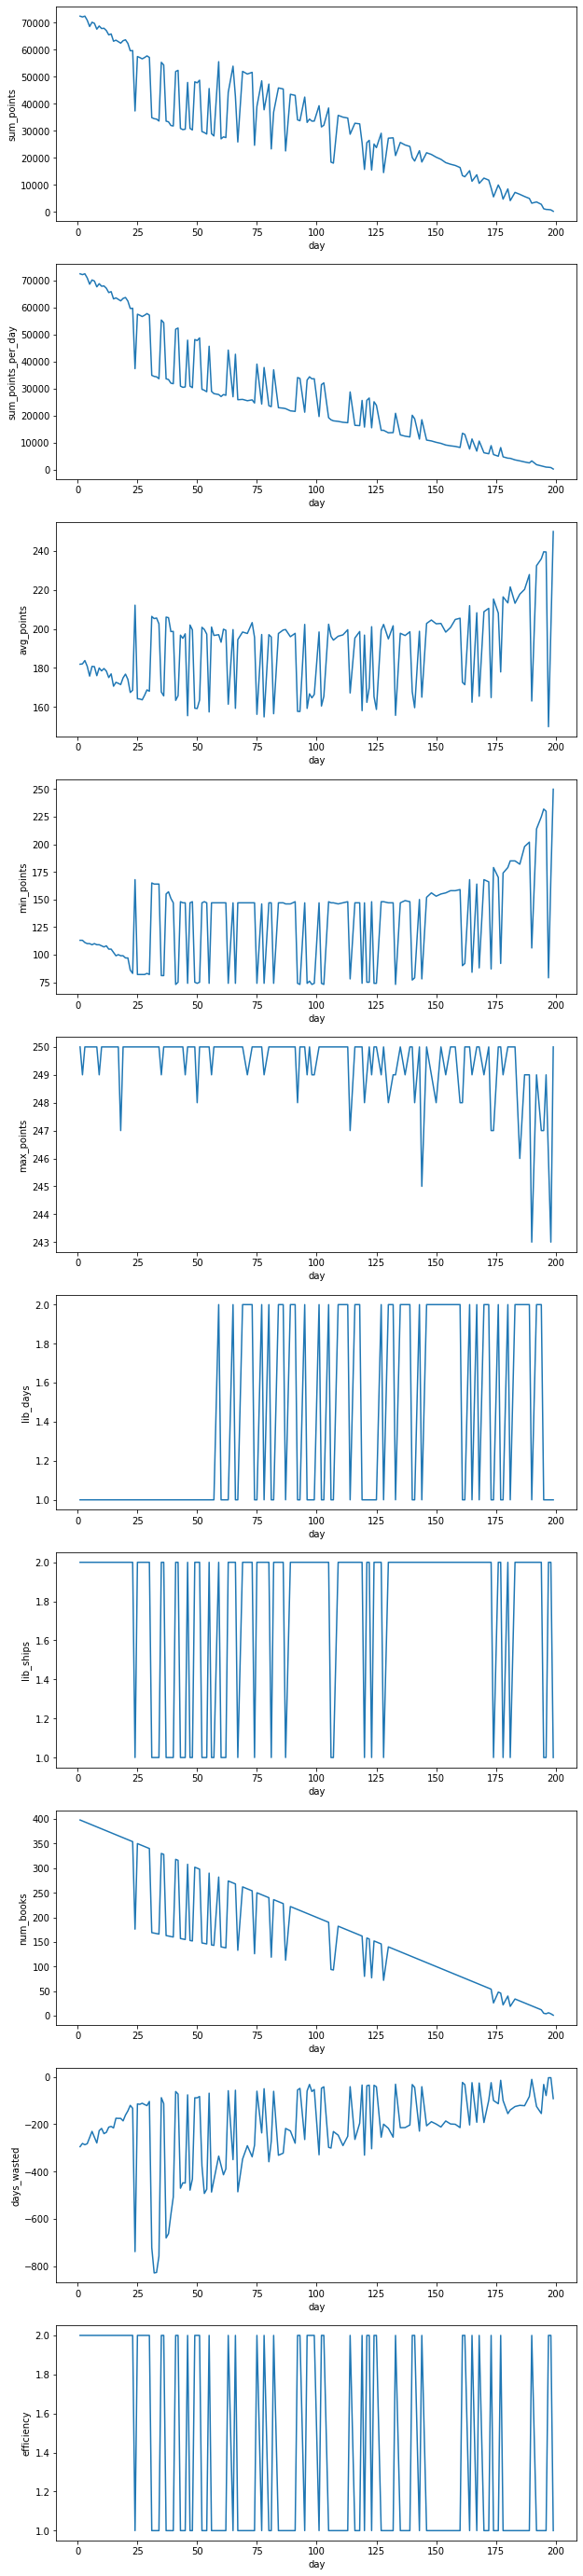

In [3]:
sim.plot_solution()

In [1]:
np.array([602, 522, 972, 157, 393, 100, 717,  72, 715, 466,  61,  59, 390,
       708,  37,  87, 607, 902, 813, 933, 952, 693, 506, 600, 158, 779,
       970,  27, 244, 665, 808, 209, 594, 690,  82, 959, 178, 597,   4,
       495, 388, 239, 476, 491, 387, 848, 854,  23, 969, 894,  69, 125,
       626, 270, 304, 478, 241, 148, 669, 736, 350, 589, 700, 944, 343,
       232, 678, 691, 971, 443, 267,   0, 852, 793, 245, 520, 828, 795,
       606, 512, 772, 575, 639, 447, 566, 844, 112, 830, 140, 653, 320,
       366, 191, 621, 737, 633,  71, 411, 160, 428, 630,  80, 316, 455,
       676, 536, 834, 798, 179, 105, 569, 510, 809, 333, 242,  56,  45,
       650, 358, 389,  62, 336, 911, 973, 234,  21, 151, 323, 273, 184,
       950, 472, 457, 200, 332, 709, 516, 233, 646, 128, 687, 217, 212,
       571, 252, 202, 135, 716,  85, 543,  81, 936, 164,  91,  83, 853,
       773, 710, 433, 247,  66, 565,  32, 805, 625, 624, 623, 186, 780,
       617, 102, 104, 837, 903, 904, 220, 213, 838, 694, 767, 175, 821,
       674, 137, 685, 124, 666, 409, 461, 494, 334, 996, 517, 486, 521,
       483, 531, 958, 313, 480, 550,  14,  31, 453, 504, 416, 924, 287,
       383, 927, 288, 437, 985, 980, 995, 993, 992, 983, 836, 815, 977,
        96, 820, 814, 107, 962,  49, 920, 908, 925,  55, 928, 931, 932,
       898,  58, 963, 891,  60,  43,  39, 949,  35,  64,  33, 850, 845,
       889, 117, 679, 118, 586, 584, 581, 577, 268, 570, 563, 556, 555,
       554, 292, 535, 534, 325, 509, 335, 500, 353, 475, 356, 462, 359,
       440, 434, 431, 399, 415, 587, 797, 260, 614, 121, 791, 782, 771,
       764, 760, 739, 729, 142, 150, 155, 174, 695, 692, 410, 197, 670,
       201, 651, 640, 634, 631, 221, 222, 622, 231, 620, 603, 998]) 

best_indices = np.array([602, 522, 972, 157, 393, 100, 717,  72, 715, 466,  61,  59, 390,
       708,  37,  87, 607, 902, 813, 933, 952, 693, 506, 600, 158, 779,
       970,  27, 244, 665, 808, 209, 594, 690,  82, 959, 178, 597,   4,
       495, 388, 239, 476, 491, 387, 848, 854,  23, 969, 894,  69, 125,
       626, 270, 304, 478, 241, 148, 669, 736, 350, 589, 700, 944, 343,
       232, 678, 691, 971, 443, 267,   0, 852, 793, 245, 520, 828, 795,
       606, 512, 772, 575, 639, 447, 566, 844, 112, 830, 140, 653, 320,
       366, 191, 621, 737, 633,  71, 411, 160, 428, 630,  80, 316, 455,
       676, 536, 834, 798, 179, 105, 569, 510, 809, 333, 242,  56,  45,
       650, 358, 389,  62, 336, 911, 973, 234,  21, 151, 323, 273, 184,
       950, 472, 457, 200, 332, 709, 516, 233, 646, 128, 687, 217, 212,
       571, 252, 202, 135, 716,  85, 543,  81, 936, 164,  91,  83, 853,
       773, 710, 433, 247,  66, 565,  32, 805])  

True

In [4]:
arr = np.arange(10)
arr[3:6] = arr[4:7]